In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
# Connect to any old simulation
dbFile = 'baseline_v1.4_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='read_example'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
# Let's compute the coadded depth on the whole sky, and then the median
bundleList = []
sql = 'filter="r"'
metric = metrics.Coaddm5Metric()
slicer = slicers.HealpixSlicer()
summaryStats = [metrics.MedianMetric()]
plotDict = {'colorMax': 27.4}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))

bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 474955 visits
Running:  ['opsim_CoaddM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 220 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 26.4898  dipole: lon: 114.745, lat: -69.26, amp: 0.44387
  mono, lon, lat, amp


Plotting complete.


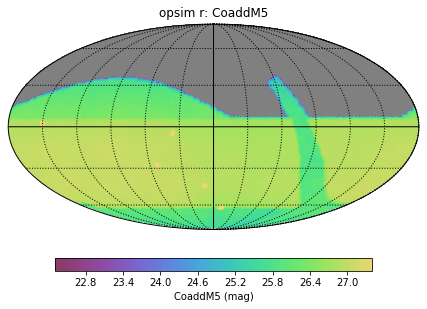

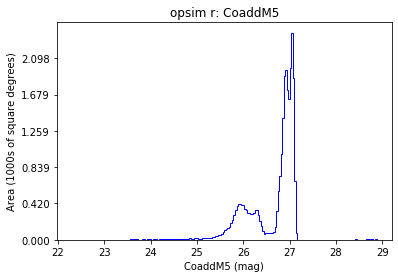

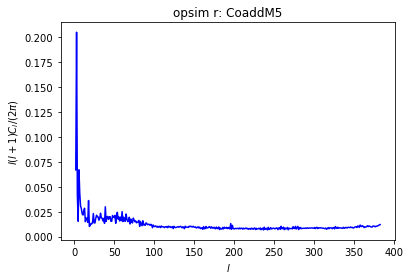

In [4]:
bg.plotAll(closefigs=False)

In [5]:
# If we look in the read_example directory, there's a .npz file with the results, and a resultsDb_sqlite.db 
# file that should should have the summary stats in there

In [6]:
ack = np.load('read_example/opsim_CoaddM5_r_HEAL.npz', allow_pickle=True)

In [7]:
list(ack.keys())

['header',
 'metricValues',
 'mask',
 'fill',
 'slicer_init',
 'slicerName',
 'slicePoints',
 'slicerNSlice',
 'slicerShape']

In [8]:
# Oh right, the output maps are numpy masked arrays, but the numpy save feature only supports regular arrays,
# so that's why this is a little messy.

In [9]:
#
ack['metricValues']

array([ 0.        ,  0.        ,  0.        , ..., 25.62115831,
       25.57629801, 25.5566183 ])

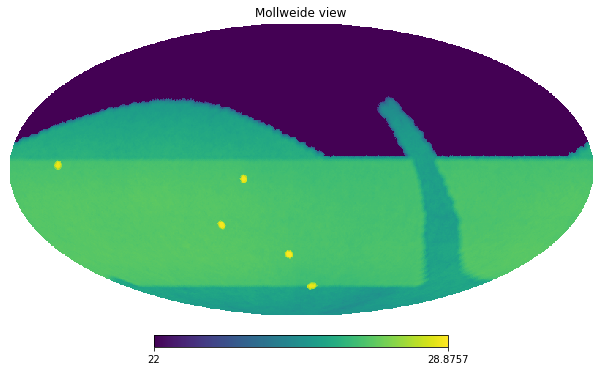

In [10]:
hp.mollview(ack['metricValues'], min=22)

In [11]:
# To really make it like it was before
import numpy.ma as ma

metricValues = ma.MaskedArray(data=ack['metricValues'],mask=ack['mask'],fill_value=ack['fill'])

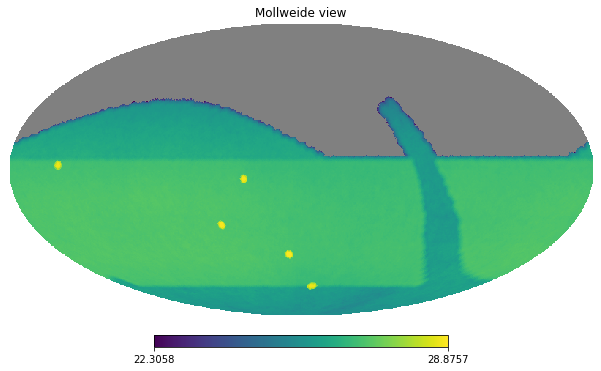

In [12]:
# Now points on the sky where there were no observations are masked and filled to the healpy unseen value
hp.mollview(metricValues)

In [13]:
# now let's pull out the summary stat that we saved
import sqlite3
import pandas as pd

con = sqlite3.connect('read_example/resultsDb_sqlite.db')
# Here's a complicated sql query to pull out the data. The idea is we can support running lots of different 
# metrics and summary stats all in one big database, but it looks a little silly when there's just one value in there
query  = 'select summaryValue from summarystats where summaryName="Median" and metricId=(select metricId from metrics where metricName="CoaddM5")'

df = pd.read_sql(query, con)

In [14]:
df

,summaryValue
0,26.883877
